# Отчет о сравнении производительности алгоритма Хеллингса, матричного и тензорного алгоритмов
### Система: Ubuntu 20.04
### Intel Core i5-8300H 2,3GHz (turbo 4.0GHz)
### RAM 16Gb DDR4
--------------------------------
### Автор: Канашин Дмитрий
### dmitrii.a.kanashin@gmail.com
--------------------------------

Данный отчет является анализом результатов, полученных в ходе постановки экспериментов над запуском алгоритмов вычисления контекстно-свободных запросов на графах.
Кроме представленных результатов о сравнении производительности, также показаны результаты сравнения работы тензорного алгоритма при разных представлениях одного и того же запроса:
- Грамматика в ослабленной форме Хомского
- Грамматика
- Рекурсивный автомат

Тут нужны уточнения.
Изначально запросы преобразовывались двумя способами:
1. По каждой продукции строится строится детерменированный автомат, по каждому переходу в автомате добавляется соответствующая продукция. Кроме этого строится продукция вида H --> s, где H --- голова, s --- стартовое состояние автомата, а H --- голова исходной продукции из запроса; из тех финальных состояний, в которых есть переход в автомате, добавляется правило f --> epsilon. В итоге грамматика получается добавлением правил из каждой исходной продукций в общее множество правил для новой грамматики, которая отражает тот же самый запрос, что и исходный. Такое преобразование выбрано, потому что запросы в своих запросах вполне могут содержать регулярный выражения в телах продукций, а в `pyformlang` есть встроенные функции для построения автомата по регулярному выражению. Возможно это не самое лучшее решение, т.к. грамматика разрастается довольно сильно в терминах количества продукций, но было все же принято, потому что целью было сравнение производительности работы алгоритмов, а не их время работы на конкретных наборах запросов и графов.
2. Третье представление запроса отличается от других тем, что из каждой продукции изначально строится рекурсивный автомат, т.е. нет цепочки "Изначальная грамматика с регулярными выражениями в телах --> грамматика без регулярных выражений --> рекурсивный автомат", где построение автомата в такой цепочке включается в часть работы тензорного алгоритма.

Кроме вычислений работы самих алгоритмов, замерялись время преобразования грамматики из состоящей продукции с регулярными выражениями в телах в грамматику без таковых и время преобразования исходной грамматики в рекурсивный автомат для третьего представления запроса.

Итого, после длительных уточнений были сделаны следующие замеры над работой алгоритмов:
- Хеллингс (грамматика в НФХ --- нормальная форма Хомского)
- Матричный алгоритм (грамматика в НФХ)
- Тензорный алгоритм (грамматика без преобразований в ОНФХ - ослабленная НФХ, преобразование в RFA --- рекурсивный автомат --- включено в время работы алгоритма)
- Тензорный алгоритм с грамматика в ОНФХ
- Тензорный алгоритм с RFA (преобразование исходного запроса в рекурсивный автомат не включено в время работы алгоритма)

В данном отчете не представлены результаты работы алгоритмов на графах из SparseGraph, потому что ожидание окончания работы хотя бы одного запроса на самом небольшом графе превысило разумные пределы.

In [9]:
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter('always', category=UserWarning)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [10]:
datasets = ['MemoryAliases', 'FullGraph', 'WorstCase']
files = ['benchmark_queries/DataForCFPQ/' + dataset + '/res.csv' for dataset in datasets ]
dataframes = dict()

for name, file_name in zip(datasets, files):
    dataframes[name] = pd.read_csv(file_name)
    
    dataframes[name]['hellings'] += dataframes[name]['Converting to cnf']
    dataframes[name]['matrices'] += dataframes[name]['Converting to cnf']
    dataframes[name]['tensor'] += dataframes[name]['Converting to cnf']
    dataframes[name]['tensor wcnf'] += dataframes[name]['Converting to cnf']
    dataframes[name]['tensor via rfa directly'] += dataframes[name]['Converting to rfa from file']

    dataframes[name] = dataframes[name].drop(['Converting to cnf', 'Converting to rfa from file'], axis=1)

In [11]:
for name, df in dataframes.items():
    dataframes[name] = pd.melt( df, id_vars=['Graph', 'Query', 'Number of pairs']
                              , value_vars=['hellings', 'matrices', 'tensor', 'tensor wcnf', 'tensor via rfa directly']
                              , var_name='algorithm', value_name='Time in seconds')

In [12]:
def print_bar(data, name, grammar, is_log=True, order=None):
    data = data[data['Query'] == grammar]
    plot = sns.catplot(x="Graph", y="Time in seconds", hue="algorithm", kind="bar", data=data, order=order)
    if is_log:
        plot.set(yscale='log')
    plot.fig.suptitle(name + ' on grammar ' + grammar)
    plot.fig.set_figwidth(18)
    plot.fig.set_figheight(9)

### Результаты работы алгоритмов на данных MemoryAliases


Всего было 3 замера времени, на диаграмме представлено среднее значение с отклонением.
Время расположено на логарифмической шкале ввиду большой разности по времени между алгоритмами.

На обеих запросах по всем графам видно, что матричный алгоритм работает гораздо быстрее двух других (по сравнению с Хеллингсом примерно в 100 раз быстрее, в сравнении с тензорным превосходит так же во много раз больше, но тут значение колеблется в зависимости от представления грамматики, которое принимает тензорный алгоритм).
Интересно, что разница во времени работы тензорного алгоритма при трех ее вариаций существенна. Например, тензорный алгоритм, которому на вход подается грамматика без преобразования в ОНФХ, работает в 10 раз медленнее, чем тот же алгоритм, которому на вход поступает непосредственно рекурсивный автомат. 

Пищу для размышлений также дают две разные грамматики g1 и g2, где во второй содержится регулярное выражение в одной из продукций. Хоть для Хеллингса и матричного алгоритма время работы в принципе не изменилось, то время работы различных версий тензорного алгоритма изменилось. Вспомним, что исходная грамматика преобразуется так, чтобы запрос остался неизменным, но в телах продукций не было бы символов регулярных выражений. Время работы тензорного алгоритма без преобразования в ОНФХ и RFA уменьшилось примерно в одинаковое количество раз почти для всех графов, в то время как время работы тензорного алгоритма с преобразованием в ОНФХ почти не изменилось, что в принципе понятно с той точки зрения, что преобразования грамматики над регулярными выражениями создают в телах сентенции длиною не больше двух символов (будь то терминал или нетерминал), а значит грамматика становится очень похожей на ту, что получается при ее преобразовании в ОНФХ.

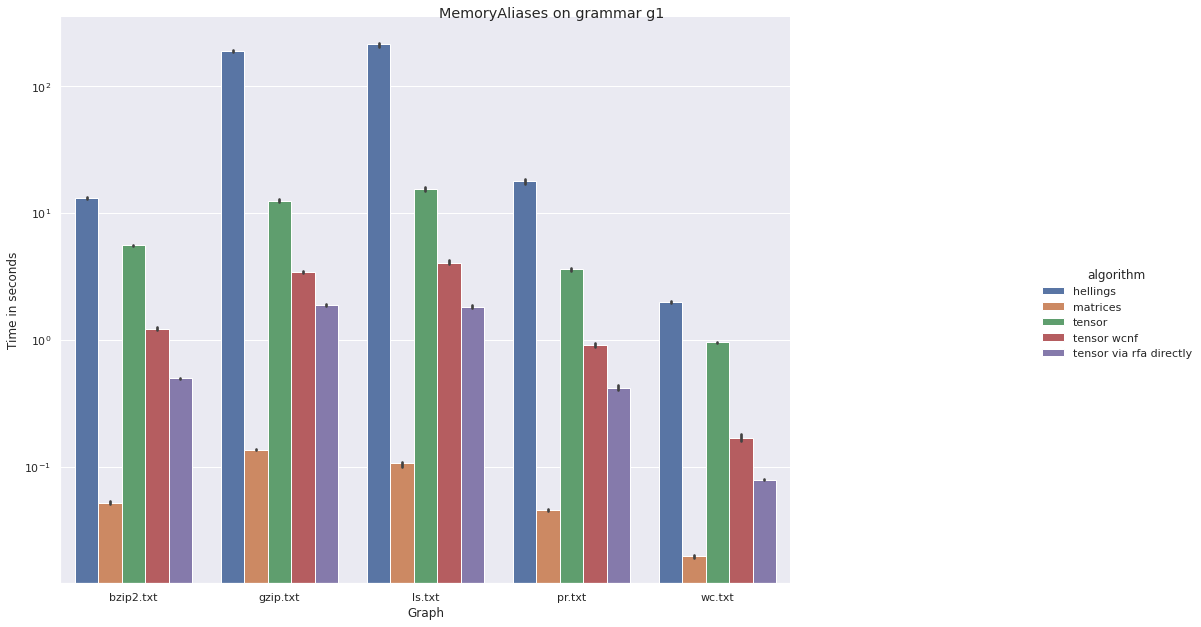

In [13]:
print_bar(dataframes['MemoryAliases'], 'MemoryAliases', 'g1')

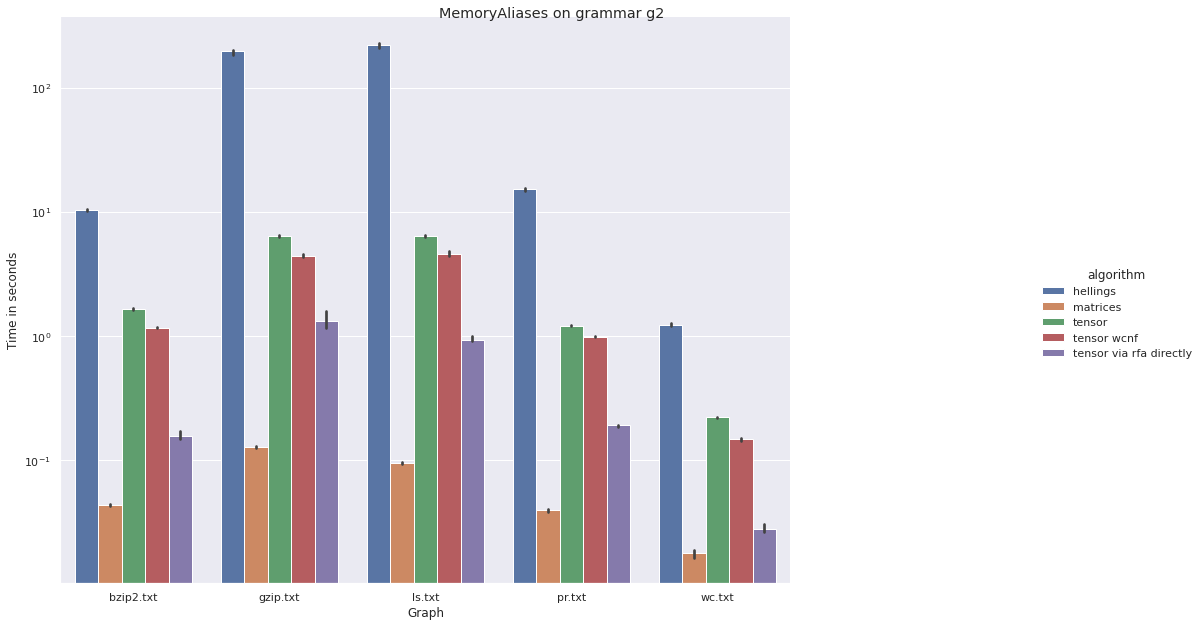

In [14]:
print_bar(dataframes['MemoryAliases'], 'MemoryAliases', 'g2')

### Результаты работы алгоритмов на данных FullGraph

Из всего набора данных замеры ставились лишь на графах размером не больше 200 рёбер, так как ожидание окончания работы алгоритмов на других графах превосходило разумные пределы, тем более на полученных результатах уже можно сделать выводы по сравнению времени работы алгоритмов. Всего было сделано 3 замера.

Соотношение всех алгоритмов между собой по времени примерно такое же, как и для данных в MemoryAliases, хотя на небольших графах (10 и 50 рёбер), Хеллингс работает немного быстрее Тензорного без и в ОНФХ на g1.

Грамматики g1, g3, g4 представляют из себя один и тот же запрос, но записанный разными грамматиками. Запрос g2 очень похож на предыдущие, но кроме того грамматика допускает пустое слово. Однако различное представление этого запроса в грамматиках на некоторых алгоритмах сильно влияет на время работы этих алгоритмов. К таким алгоритмам не относится матричный, он является устойчивым в плане разрастания грамматики (в чем и состоит различие грамматик g1-g4), при этом оставаясь самым быстрым среди всех алгоритмов.

Более интересная ситуация у алгоритма Хеллингса, который один и тот же запрос обрабатывает в разы дольше, когда грамматика больше, и это прирост во времени увеличивается с количеством ребер. Так, например, для графа с 200 рёрбрами Хеллингс работает в 10 раз дольше на g4 по сравнению с g1 и g2.

Среди всех реализаций тензорного алгоритма самой быстрой так же остается RFA, как и в MemoryAliases. Что действительно интересно --- все реализации работают быстрее, когда исходная грамматика становится больше по количеству продукций. Это может быть объяснено тем, что хоть она и разрастается, но принимает все более схожий с ОНФХ вид.

Заметна так же тенденция, что один и тот же запрос, но записанный через регулярное выражение (как в g2, по сравнению с g1), обрабатывается быстрее тензорным алгоритмом не в ОНФХ на примере g1 и g2, более того время работы тензорного алгоритма не в ОНФХ в среднем было немного но меньше, чем в ОНФХ.

Так же запрос в виде грамматики g2 с регулярным выражением обрабатывается быстрее RFA, чем тот же g1 без регулярных выражений примерно в 10 раз. При этом запросы g3 и g4 обрабатываются примерно с той же скоростью что и на g2.

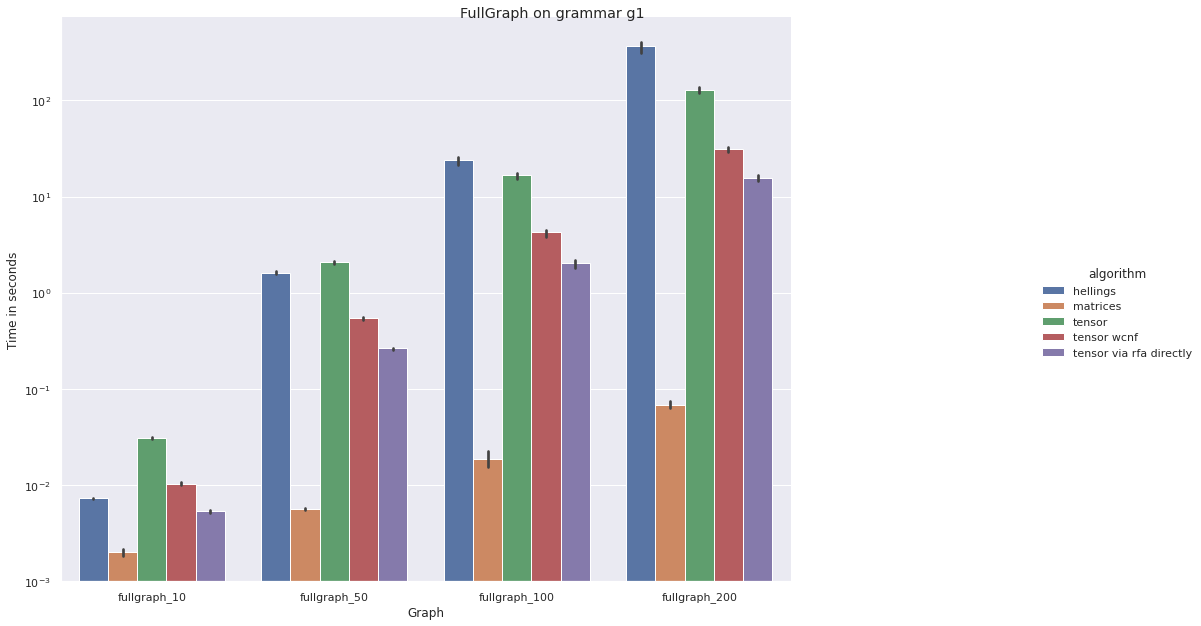

In [15]:
sorted_names = [f'fullgraph_{num}' for num in [10, 50, 100, 200]]

print_bar(dataframes['FullGraph'], 'FullGraph', 'g1', order=sorted_names)

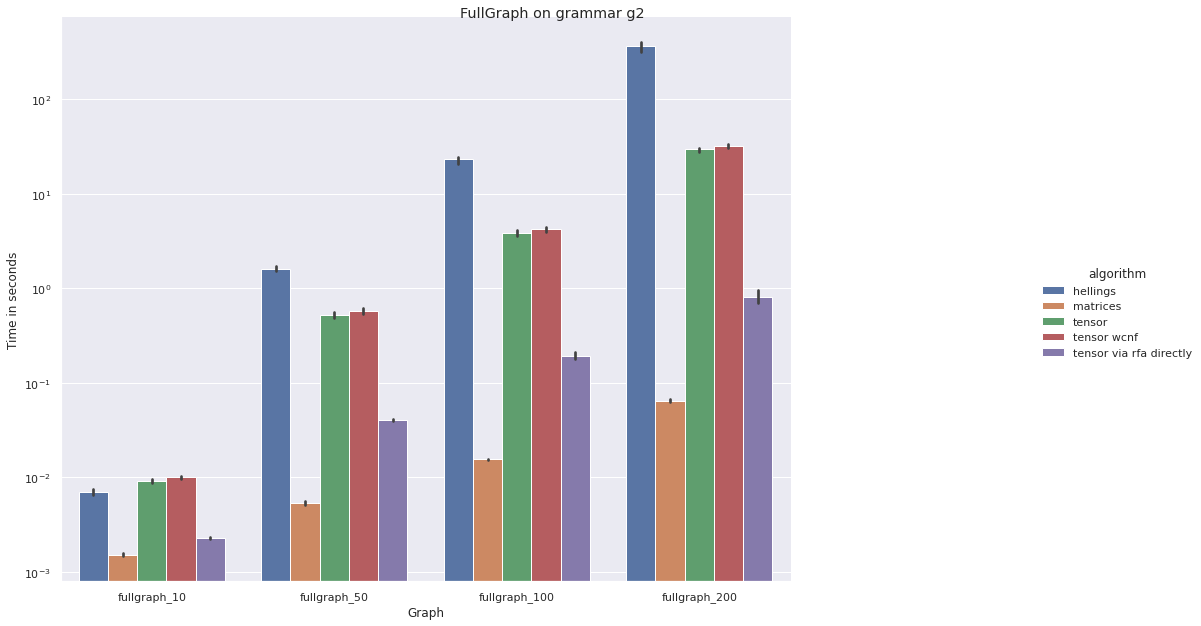

In [16]:
sorted_names = [f'fullgraph_{num}' for num in [10, 50, 100, 200]]

print_bar(dataframes['FullGraph'], 'FullGraph', 'g2', order=sorted_names)

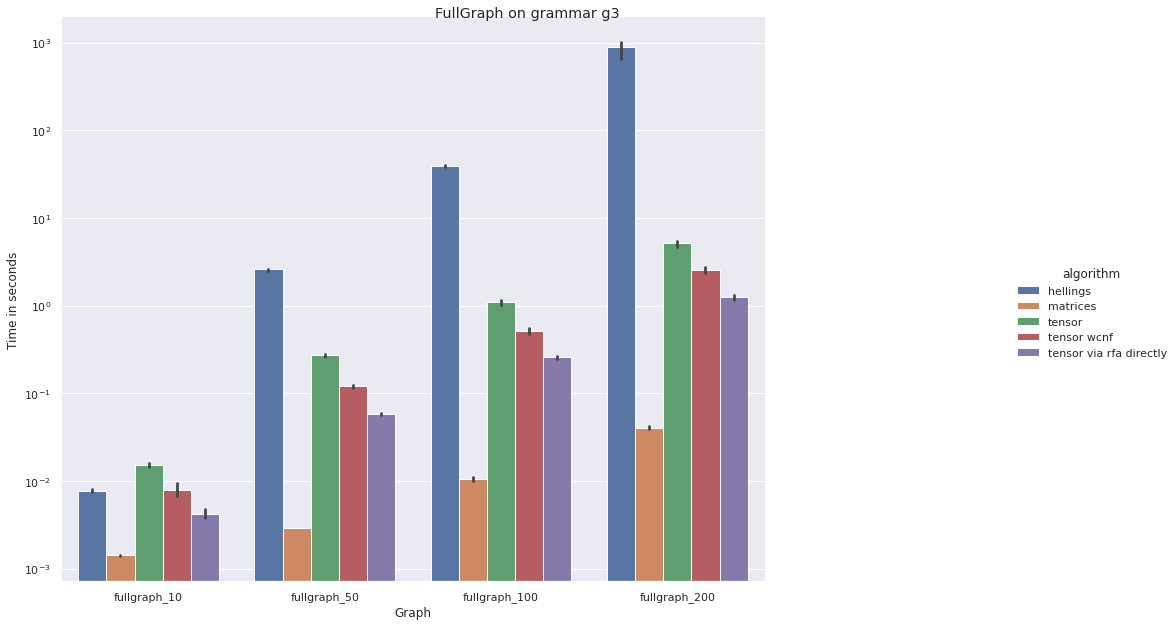

In [17]:
sorted_names = [f'fullgraph_{num}' for num in [10, 50, 100, 200]]

print_bar(dataframes['FullGraph'], 'FullGraph', 'g3', order=sorted_names)

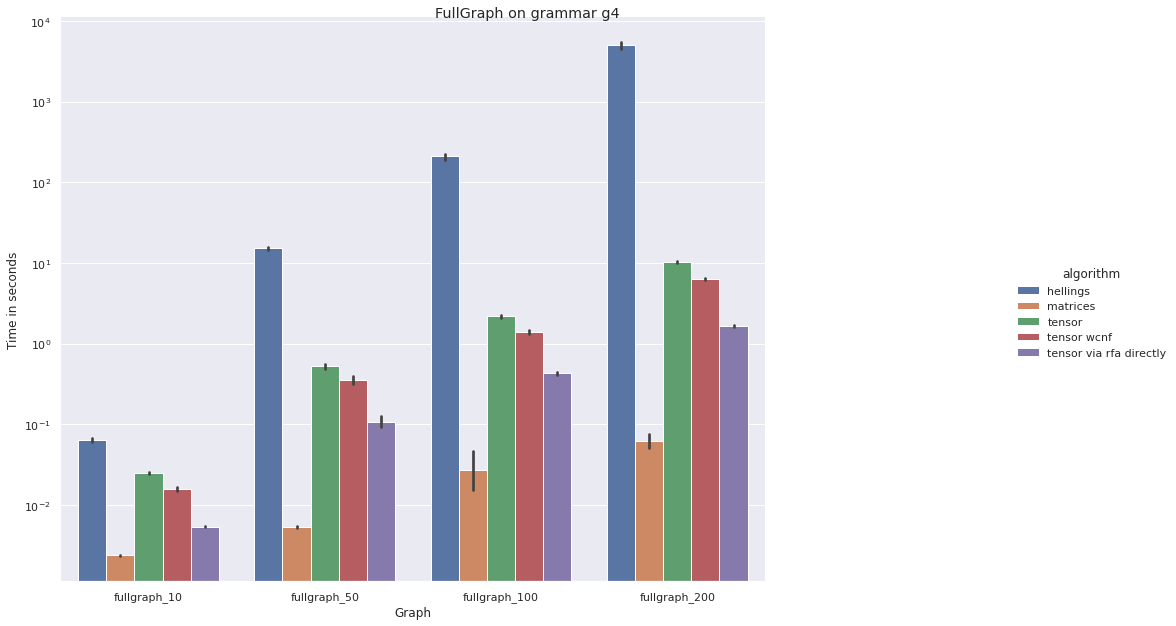

In [18]:
sorted_names = [f'fullgraph_{num}' for num in [10, 50, 100, 200]]

print_bar(dataframes['FullGraph'], 'FullGraph', 'g4', order=sorted_names)

# Результаты работы алгоритмов на WorstCase

В данном наборе графов были сделаны замеры вплоть до графа с размером в 256 по причине долгой работы (больше часа) уже на графе с 256 рёбрами, но по диаграмме видно, что время соотношение работы всех алгоритмов примерно одинаково изменяется с ростом графа, так что можно получить вполне правдивые выводы касаемо соотношения времени работы алгоритмов. Несмотря на то, что здесь был сделан лишь один замер, правдоподобность относительно разницы в скорости работы алгоритмов в представленных результах не должна быть уменьшена.

На небольших графах (до 32 рёбер включительно) Хеллингс отрабатывает быстрее всех алгоритмов, но уже при больших размерах графа матричный алгоритм остается впереди и на графе с 256 рёбрами, матричный алгоритм работает быстрее примерно в 10 раз ближайшего конкурента --- Хелингса. Все вариации тензорного алгоритма отрабатывают медленнее двух других алгоритмов, при этом реализация через RFA работает быстрее двух других вариаций.

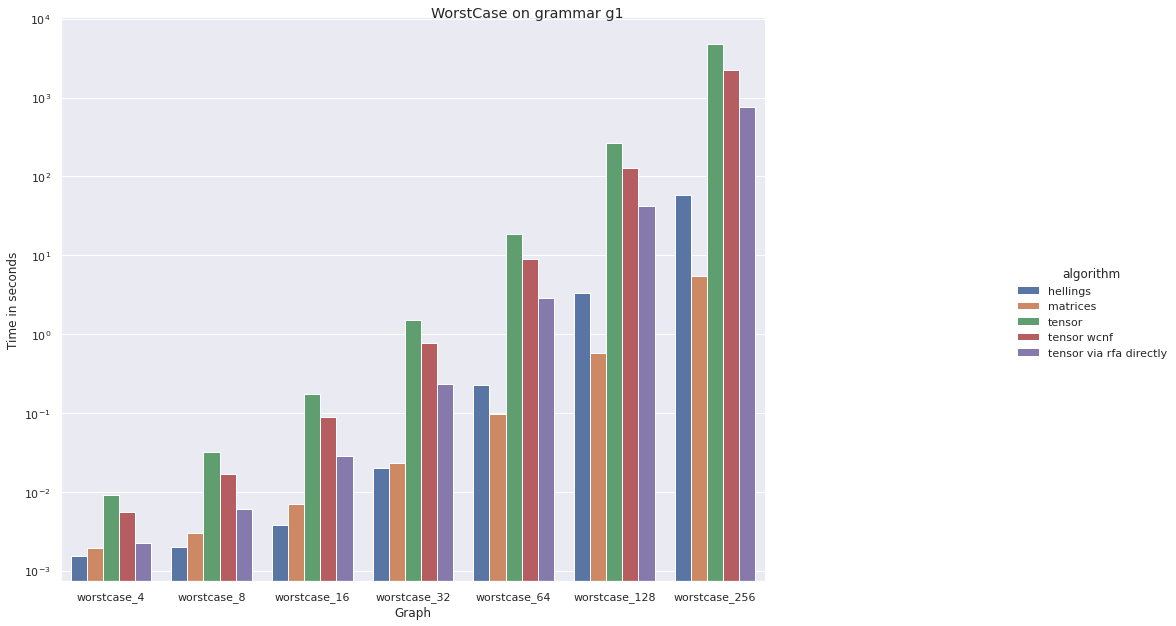

In [19]:
sorted_names = [f'worstcase_{num}' for num in [2 ** i for i in range(2, 9)]]

print_bar(dataframes['WorstCase'], 'WorstCase', 'g1', order=sorted_names)

## Выводы

1. Матричный алгоритм является несомненно самым быстрым среди всех алгоритмов в значительной степени
2. Среди реализаций тензорного алгоритма самой быстрой оказалась RFA реализация. Что неудивительно, ведь в других реализациях этого алгоритма при передаче преобразованных разросшихся грамматик получается довольно большой рекурсивный автомат, в то время как построенный автомат напрямую из исходной грамматики получается гораздо меньше, что более всего заметно на грамматиках, содержащих регулярное выражение.
3. Самым долгим по времени работы оказался алгоритм Хеллингса, хотя на графах с худшим случаем он и отрабатывал быстрее, чем тензорный, а местами, при небольших графах и быстрее матричного, но при более сложных запросах и других графах время его работы десятки раз отставало от других алгоритмов.

In [20]:
print('MemoryAliases')

df = pd.read_csv(files[0])
df

MemoryAliases


,Graph,Query,Converting to cnf,Converting to rfa from file,hellings,matrices,tensor,tensor wcnf,tensor via rfa directly,Number of pairs
0,bzip2.txt,g1,0.004166,0.002235,12.830304,0.046355,5.574622,1.187185,0.502560,315
1,bzip2.txt,g2,0.003066,0.001935,10.118762,0.040259,1.613397,1.165979,0.151774,315
2,gzip.txt,g1,0.004099,0.002677,186.841022,0.130467,12.178035,3.334021,1.847888,1458
3,gzip.txt,g2,0.002896,0.001809,183.804324,0.124283,6.359817,4.368185,1.171005,1458
4,ls.txt,g1,0.003912,0.002194,201.548839,0.094937,14.822444,3.924515,1.784283,854
5,ls.txt,g2,0.002939,0.001816,209.157438,0.094087,6.260709,4.405789,0.910543,854
6,pr.txt,g1,0.004149,0.003734,16.935344,0.040958,3.488147,0.881423,0.398637,385
7,pr.txt,g2,0.002928,0.001844,14.729920,0.035813,1.200998,0.974947,0.185293,385
8,wc.txt,g1,0.003899,0.002096,1.941429,0.015330,0.945883,0.156855,0.075911,156
9,wc.txt,g2,0.002937,0.001813,1.201964,0.013614,0.215373,0.139870,0.024852,156


In [21]:
print('FullGraph')

df = pd.read_csv(files[1])
df

FullGraph


,Graph,Query,Converting to cnf,Converting to rfa from file,hellings,matrices,tensor,tensor wcnf,tensor via rfa directly,Number of pairs
0,fullgraph_10,g1,0.001307,0.000523,0.005900,0.000846,0.028623,0.008596,0.004617,100
1,fullgraph_10,g2,0.000842,0.000362,0.005711,0.000743,0.007977,0.008892,0.001957,100
2,fullgraph_10,g3,0.001070,0.000475,0.006323,0.000365,0.013265,0.008384,0.004360,100
3,fullgraph_10,g4,0.001642,0.000914,0.057827,0.000765,0.022541,0.013343,0.004342,100
4,fullgraph_100,g1,0.000966,0.000556,21.178732,0.014403,15.217115,3.754406,1.824649,10000
5,fullgraph_100,g2,0.000670,0.000328,20.941696,0.014534,3.571737,3.919090,0.184316,10000
6,fullgraph_100,g3,0.000956,0.000491,37.830278,0.010199,1.019099,0.479412,0.243161,10000
7,fullgraph_100,g4,0.001505,0.000866,189.551531,0.044618,2.075212,1.308050,0.408764,10000
8,fullgraph_200,g1,0.001039,0.000505,315.045610,0.061935,119.089613,29.288766,14.362561,40000
9,fullgraph_200,g2,0.000690,0.000356,314.705098,0.062532,27.953004,30.561561,0.697841,40000


In [22]:
print('WorstCase')

df = pd.read_csv(files[2])
df

WorstCase


,Graph,Query,Converting to cnf,Converting to rfa from file,hellings,matrices,tensor,tensor wcnf,tensor via rfa directly,Number of pairs
0,worstcase_128,g1,0.019379,0.000764,3.277813,0.564625,264.088391,127.764584,42.106758,4160
1,worstcase_16,g1,0.001315,0.000726,0.002445,0.005738,0.170729,0.088360,0.027982,72
2,worstcase_32,g1,0.001412,0.000820,0.018693,0.022116,1.521439,0.765230,0.235478,272
3,worstcase_4,g1,0.001311,0.000712,0.000235,0.000623,0.007847,0.004189,0.001527,6
4,worstcase_64,g1,0.001302,0.000732,0.226954,0.096663,18.687579,9.078322,2.870005,1056
5,worstcase_8,g1,0.001372,0.000729,0.000601,0.001666,0.030404,0.015683,0.005283,20
6,worstcase_256,g1,0.001600,0.000812,58.857391,5.485176,4811.969428,2264.842838,767.951012,16512
